# Anomaly detection based on the U-Net model 

### Loading the dataset

Prepare dataset from label_n_full.csv files where n is 0, 1, 2, 3
Next, we will seperate the data into train, validation and test sets with a ratio of 0.7 : 0.15 : 0.15

In [22]:
import pandas as pd
import numpy as np

label_0 = pd.read_csv("data/label_0_full.csv")
label_1 = pd.read_csv("data/label_1_full.csv")
label_2 = pd.read_csv("data/label_2_full.csv")
label_3 = pd.read_csv("data/label_3_full.csv")

len_0 = len(label_0)
len_1 = len(label_1)
len_2 = len(label_2)
len_3 = len(label_3)

label_X = [label_0, label_1, label_2, label_3]
rem = [len_0, len_1, len_2, len_3]

for i in range(4):
    r = rem[i] % 100
    label_X[i] = label_X[i].iloc[:rem[i] - r]

    print(len(label_X[i]))

data_split_0 = np.array_split(label_X[0], len(label_X[0]) // 100)
data_split_1 = np.array_split(label_X[1], len(label_X[1]) // 100)
data_split_2 = np.array_split(label_X[2], len(label_X[2]) // 100)
data_split_3 = np.array_split(label_X[3], len(label_X[3]) // 100)

y_label_0 = np.zeros((len(data_split_0), 100))  
y_label_1 = np.ones((len(data_split_1), 100))   
y_label_2 = np.full((len(data_split_2), 100), 2)  
y_label_3 = np.full((len(data_split_3), 100), 3)

print(len(data_split_1), len(data_split_1[0]))

train_ratio = 0.7
temp_ratio = 0.3  # for both val and test combined
val_ratio = 0.5  # 50% of temp_ratio for validation
test_ratio = temp_ratio / 2  # same as val_ratio

data_splits = [data_split_0, data_split_1, data_split_2, data_split_3]
y_data_splits = [y_label_0, y_label_1, y_label_2, y_label_3]

train_sizes = []
train_data = []
val_data = []
test_data = []

y_train_data = []
y_val_data = []
y_test_data = []

for i in range(4):
    data_len = len(data_splits[i])
    train_size = int(data_len * train_ratio)
    temp_size = data_len - train_size 
    val_size = int(temp_size * val_ratio)
    
    # Split the data
    train_sizes.append(train_size)
    train_data.append(data_splits[i][:train_size])
    val_data.append(data_splits[i][train_size:train_size + val_size])
    test_data.append(data_splits[i][train_size + val_size:])

    # Split the labels
    y_train_data.append(y_data_splits[i][:train_size])
    y_val_data.append(y_data_splits[i][train_size:train_size + val_size])
    y_test_data.append(y_data_splits[i][train_size + val_size:])

# check the lengths of each split
for i in range(4):
    print(f"Data split {i}: train + val + test =", len(train_data[i]), "+", len(val_data[i]), "+", len(test_data[i]))

# Concatenate all splits across the 4 data parts
x_train_concat = np.concatenate(train_data, axis=0)
x_val_concat = np.concatenate(val_data, axis=0)
x_test_concat = np.concatenate(test_data, axis=0)

y_train_concat = np.concatenate(y_train_data, axis=0)
y_val_concat = np.concatenate(y_val_data, axis=0)
y_test_concat = np.concatenate(y_test_data, axis=0)

# Output final shapes to confirm correct splitting
print("Train data shape:", x_train_concat.shape)
print("Validation data shape:", x_val_concat.shape)
print("Test data shape:", x_test_concat.shape)



1445800
1440100
1414800
1439900


/Users/seyeong/anaconda3/envs/anomaly_detection/lib/python3.10/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


14401 100
Data split 0: train + val + test = 10120 + 2169 + 2169
Data split 1: train + val + test = 10080 + 2160 + 2161
Data split 2: train + val + test = 9903 + 2122 + 2123
Data split 3: train + val + test = 10079 + 2160 + 2160
Train data shape: (40182, 100, 3)
Validation data shape: (8611, 100, 3)
Test data shape: (8613, 100, 3)


In [27]:
y_train_concat[0]
y_train_concat.shape

(40182, 100)

Convert y value to one-hot encoding 

In [28]:
from keras.utils import to_categorical

# Convert y_train and y_valid to one-hot encoding
y_train_one_hot = to_categorical(y_train_concat, num_classes=4) 
y_valid_one_hot = to_categorical(y_val_concat, num_classes=4)  
y_test_one_hot = to_categorical(y_test_concat, num_classes=4) 

# Check the shape
print(y_train_one_hot.shape) 
print(y_valid_one_hot.shape) 
print(y_test_one_hot.shape) 

(40182, 100, 4)
(8611, 100, 4)
(8613, 100, 4)


In [30]:
y_train_one_hot.shape

(40182, 100, 4)

In [32]:
import tensorflow as tf
from tensorflow.keras import layers, models

batch_size_ = len(y_train_concat)
# Define the U-Net model
def unet_model(input_shape=(100, 3), num_classes=4):
    inputs = layers.Input(input_shape)

    # Encoder (downsampling path)
    conv1 = layers.Conv1D(32, kernel_size=3, activation='relu', padding='same')(inputs)
    conv1 = layers.Conv1D(32, kernel_size=3, activation='relu', padding='same')(conv1)
    pool1 = layers.MaxPooling1D(2)(conv1)

    conv2 = layers.Conv1D(64, kernel_size=3, activation='relu', padding='same')(pool1)
    conv2 = layers.Conv1D(64, kernel_size=3, activation='relu', padding='same')(conv2)
    pool2 = layers.MaxPooling1D(2)(conv2)

    conv3 = layers.Conv1D(128,  kernel_size=3, activation='relu', padding='same')(pool2)
    conv3 = layers.Conv1D(128,  kernel_size=3, activation='relu', padding='same')(conv3)
    pool3 = layers.MaxPooling1D(pool_size=2)(conv3)

    conv4 = layers.Conv1D(256,  kernel_size=3, activation='relu', padding='same')(pool3)
    conv4 = layers.Conv1D(256,  kernel_size=3, activation='relu', padding='same')(conv4)
    pool4 = layers.MaxPooling1D(pool_size=2)(conv4)

    # Bottleneck
    conv5 = layers.Conv1D(512,  kernel_size=3, activation='relu', padding='same')(pool4)
    conv5 = layers.Conv1D(512,  kernel_size=3, activation='relu', padding='same')(conv5)

    # Decoder (upsampling path)
    up6 = layers.Conv1DTranspose(256, kernel_size=2, strides=2, padding='same')(conv5)
    print(up6.shape, conv4.shape)
    up6 = layers.concatenate([up6, conv4])

    conv6 = layers.Conv1D(256,  kernel_size=3, activation='relu', padding='same')(up6)
    conv6 = layers.Conv1D(256,  kernel_size=3, activation='relu', padding='same')(conv6)

    up7 = layers.Conv1DTranspose(128, kernel_size=2, strides=2, padding='same')(conv6)
    up7 = layers.ZeroPadding1D(padding=(1, 0))(up7)
    print(up7.shape, conv3.shape)
    up7 = layers.concatenate([up7, conv3])
    conv7 = layers.Conv1D(128,  kernel_size=3, activation='relu', padding='same')(up7)
    conv7 = layers.Conv1D(128,  kernel_size=3, activation='relu', padding='same')(conv7)

    up8 = layers.Conv1DTranspose(64, kernel_size=2, strides=2, padding='same')(conv7)
    up8 = layers.concatenate([up8, conv2])
    conv8 = layers.Conv1D(64,  kernel_size=3, activation='relu', padding='same')(up8)
    conv8 = layers.Conv1D(64,  kernel_size=3, activation='relu', padding='same')(conv8)

    up9 = layers.Conv1DTranspose(32, kernel_size=2, strides=2, padding='same')(conv8)
    up9 = layers.concatenate([up9, conv1])
    conv9 = layers.Conv1D(32,  kernel_size=3, activation='relu', padding='same')(up9)
    conv9 = layers.Conv1D(32,  kernel_size=3, activation='relu', padding='same')(conv9)

    # Output layer for multi-class classification (4 classes)
    outputs = layers.Conv1D(num_classes, kernel_size=1, activation='softmax')(conv9)

    # Model compilation
    model = models.Model(inputs=[inputs], outputs=[outputs])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    return model

# Instantiate and view the model summary
model = unet_model()
model.summary()


(None, 12, 256) (None, 12, 256)
(None, 25, 128) (None, 25, 128)


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_6       │ (None, 100, 3)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_58 (Conv1D)  │ (None, 100, 32)   │        320 │ input_layer_6[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_59 (Conv1D)  │ (None, 100, 32)   │      3,104 │ conv1d_58[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_16    │ (None, 50, 32)    │          0 │ conv1d_59[0][0]   │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_60 (Conv1D)  │ (None, 50, 64)    │      6,208 │ max_pooling1d_16… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_61 (Conv1D)  │ (None, 50, 64)    │     12,352 │ conv1d_60[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_17    │ (None, 25, 64)    │          0 │ conv1d_61[0][0]   │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_62 (Conv1D)  │ (None, 25, 128)   │     24,704 │ max_pooling1d_17… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_63 (Conv1D)  │ (None, 25, 128)   │     49,280 │ conv1d_62[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_18    │ (None, 12, 128)   │          0 │ conv1d_63[0][0]   │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_64 (Conv1D)  │ (None, 12, 256)   │     98,560 │ max_pooling1d_18… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_65 (Conv1D)  │ (None, 12, 256)   │    196,864 │ conv1d_64[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_19    │ (None, 6, 256)    │          0 │ conv1d_65[0][0]   │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_66 (Conv1D)  │ (None, 6, 512)    │    393,728 │ max_pooling1d_19… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_67 (Conv1D)  │ (None, 6, 512)    │    786,944 │ conv1d_66[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_transpose_10 │ (None, 12, 256)   │    262,400 │ conv1d_67[0][0]   │
│ (Conv1DTranspose)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_10      │ (None, 12, 512)   │          0 │ conv1d_transpose… │
│ (Concatenate)       │                   │            │ conv1d_65[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_68 (Conv1D)  │ (None, 12, 256)   │    393,472 │ concatenate_10[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_69 (Conv1D)  │ (None, 12, 256)   │    196,864 │ conv1d_68[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_transpose_11 │ (None, 24, 128)   │     65,664 │ conv1d_69[0][0]   │
│ (Conv1DTranspose)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding1d_1    │ (None, 25, 128)   │          0 │ conv1d_transpose

 Total params: 2,705,156 (10.32 MB)

 Trainable params: 2,705,156 (10.32 MB)

 Non-trainable params: 0 (0.00 B)

In [61]:
# model2 

# Define the U-Net model
def unet_model(input_shape=(100, 3), num_classes=4):
    inputs = layers.Input(input_shape)

    # Encoder (downsampling path)
    conv1 = layers.Conv1D(32, kernel_size=3, activation='relu', padding='same')(inputs)
    conv1 = layers.Conv1D(32, kernel_size=3, activation='relu', padding='same')(conv1)
    pool1 = layers.MaxPooling1D(2)(conv1)

    conv2 = layers.Conv1D(64, kernel_size=3, activation='relu', padding='same')(pool1)
    conv2 = layers.Conv1D(64, kernel_size=3, activation='relu', padding='same')(conv2)
    pool2 = layers.MaxPooling1D(2)(conv2)

    conv3 = layers.Conv1D(128,  kernel_size=3, activation='relu', padding='same')(pool2)
    conv3 = layers.Conv1D(128,  kernel_size=3, activation='relu', padding='same')(conv3)



    up8 = layers.Conv1DTranspose(64, kernel_size=2, strides=2, padding='same')(conv3)
    up8 = layers.concatenate([up8, conv2])
    conv8 = layers.Conv1D(64,  kernel_size=3, activation='relu', padding='same')(up8)
    conv8 = layers.Conv1D(64,  kernel_size=3, activation='relu', padding='same')(conv8)

    up9 = layers.Conv1DTranspose(32, kernel_size=2, strides=2, padding='same')(conv8)
    up9 = layers.concatenate([up9, conv1])
    conv9 = layers.Conv1D(32,  kernel_size=3, activation='relu', padding='same')(up9)
    conv9 = layers.Conv1D(32,  kernel_size=3, activation='relu', padding='same')(conv9)

    # Output layer for multi-class classification (4 classes)
    outputs = layers.Conv1D(num_classes, kernel_size=1, activation='softmax')(conv9)

    # Model compilation
    model = models.Model(inputs=[inputs], outputs=[outputs])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    return model

# Instantiate and view the model summary
model = unet_model()
model.summary()


ValueError: A `Concatenate` layer requires inputs with matching shapes except for the concatenation axis. Received: input_shape=[(None, 24, 64), (None, 50, 64)]

In [71]:
from keras import layers, models, regularizers

# Define the U-Net model with L1 and L2 regularization
def unet_model(input_shape=(100, 3), num_classes=4, l1_lambda=1e-2, l2_lambda=1e-2):
    inputs = layers.Input(input_shape)

    # Encoder (downsampling path)
    conv1 = layers.Conv1D(32, kernel_size=3, activation='relu', padding='same',
                          kernel_regularizer=regularizers.l1_l2(l1=l1_lambda, l2=l2_lambda))(inputs)
    conv1 = layers.Conv1D(32, kernel_size=3, activation='relu', padding='same',
                          kernel_regularizer=regularizers.l1_l2(l1=l1_lambda, l2=l2_lambda))(conv1)
    pool1 = layers.MaxPooling1D(2)(conv1)

    conv2 = layers.Conv1D(64, kernel_size=3, activation='relu', padding='same',
                          kernel_regularizer=regularizers.l1_l2(l1=l1_lambda, l2=l2_lambda))(pool1)
    conv2 = layers.Conv1D(64, kernel_size=3, activation='relu', padding='same',
                          kernel_regularizer=regularizers.l1_l2(l1=l1_lambda, l2=l2_lambda))(conv2)
    pool2 = layers.MaxPooling1D(2)(conv2)

    conv3 = layers.Conv1D(128, kernel_size=3, activation='relu', padding='same',
                          kernel_regularizer=regularizers.l1_l2(l1=l1_lambda, l2=l2_lambda))(pool2)
    conv3 = layers.Conv1D(128, kernel_size=3, activation='relu', padding='same',
                          kernel_regularizer=regularizers.l1_l2(l1=l1_lambda, l2=l2_lambda))(conv3)

    up8 = layers.Conv1DTranspose(64, kernel_size=2, strides=2, padding='same')(conv3)
    up8 = layers.concatenate([up8, conv2])
    conv8 = layers.Conv1D(64, kernel_size=3, activation='relu', padding='same',
                          kernel_regularizer=regularizers.l1_l2(l1=l1_lambda, l2=l2_lambda))(up8)
    conv8 = layers.Conv1D(64, kernel_size=3, activation='relu', padding='same',
                          kernel_regularizer=regularizers.l1_l2(l1=l1_lambda, l2=l2_lambda))(conv8)

    up9 = layers.Conv1DTranspose(32, kernel_size=2, strides=2, padding='same')(conv8)
    up9 = layers.concatenate([up9, conv1])
    conv9 = layers.Conv1D(32, kernel_size=3, activation='relu', padding='same',
                          kernel_regularizer=regularizers.l1_l2(l1=l1_lambda, l2=l2_lambda))(up9)
    conv9 = layers.Conv1D(32, kernel_size=3, activation='relu', padding='same',
                          kernel_regularizer=regularizers.l1_l2(l1=l1_lambda, l2=l2_lambda))(conv9)

    # Output layer for multi-class classification (4 classes)
    outputs = layers.Conv1D(num_classes, kernel_size=1, activation='softmax')(conv9)

    # Model compilation
    model = models.Model(inputs=[inputs], outputs=[outputs])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    return model

# Instantiate and view the model summary
model = unet_model()
model.summary()


Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_11      │ (None, 100, 3)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_116 (Conv1D) │ (None, 100, 32)   │        320 │ input_layer_11[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_117 (Conv1D) │ (None, 100, 32)   │      3,104 │ conv1d_116[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_29    │ (None, 50, 32)    │          0 │ conv1d_117[0][0]  │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_118 (Conv1D) │ (None, 50, 64)    │      6,208 │ max_pooling1d_29… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_119 (Conv1D) │ (None, 50, 64)    │     12,352 │ conv1d_118[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_30    │ (None, 25, 64)    │          0 │ conv1d_119[0][0]  │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_120 (Conv1D) │ (None, 25, 128)   │     24,704 │ max_pooling1d_30… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_121 (Conv1D) │ (None, 25, 128)   │     49,280 │ conv1d_120[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_transpose_21 │ (None, 50, 64)    │     16,448 │ conv1d_121[0][0]  │
│ (Conv1DTranspose)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_21      │ (None, 50, 128)   │          0 │ conv1d_transpose… │
│ (Concatenate)       │                   │            │ conv1d_119[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_122 (Conv1D) │ (None, 50, 64)    │     24,640 │ concatenate_21[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_123 (Conv1D) │ (None, 50, 64)    │     12,352 │ conv1d_122[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_transpose_22 │ (None, 100, 32)   │      4,128 │ conv1d_123[0][0]  │
│ (Conv1DTranspose)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_22      │ (None, 100, 64)   │          0 │ conv1d_transpose… │
│ (Concatenate)       │                   │            │ conv1d_117[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_124 (Conv1D) │ (None, 100, 32)   │      6,176 │ concatenate_22[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_125 (Conv1D) │ (None, 100, 32)   │      3,104 │ conv1d_124[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_126 (Conv1D) │ (None, 100, 4)    │        132 │ conv1d_125[0][0]  │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 162,948 (636.52 KB)

 Trainable params: 162,948 (636.52 KB)

 Non-trainable params: 0 (0.00 B)

In [67]:
from keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor='loss', patience=1, verbose=1)

In [73]:
history = model.fit(
    x_train_concat, y_train_one_hot,  # Ensure y_train is one-hot encoded for multi-class
    epochs=20,
    batch_size=32,
    validation_data=(x_val_concat, y_valid_one_hot),
    verbose=1,
    # class_weight=class_weights_dict,
    callbacks=[early_stop]
)

# Save the model
model.save("u_net_v5.h5")

Epoch 1/20
1256/1256 ━━━━━━━━━━━━━━━━━━━━ 16s 13ms/step - accuracy: 0.2488 - loss: 1.5627 - val_accuracy: 0.2508 - val_loss: 1.5663
Epoch 2/20
1256/1256 ━━━━━━━━━━━━━━━━━━━━ 16s 13ms/step - accuracy: 0.2488 - loss: 1.5671 - val_accuracy: 0.2519 - val_loss: 1.5684
Epoch 2: early stopping


In [41]:
# model2
loss, accuracy = model.evaluate(x_test_concat, y_test_one_hot, verbose=1)
print(loss)
print(accuracy)

270/270 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.4027 - loss: 6.9615
3.0094895362854004
0.7359337210655212


In [65]:
# model3
loss, accuracy = model.evaluate(x_test_concat, y_test_one_hot, verbose=1)
print(loss)
print(accuracy)

270/270 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.2817 - loss: 13.3503
7.1685919761657715
0.4819646179676056


In [70]:
# model4 (saved as u_net_v3.h5)
loss, accuracy = model.evaluate(x_test_concat, y_test_one_hot, verbose=1)
print(loss)
print(accuracy)

270/270 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.0364 - loss: 1.4042
1.4042704105377197
0.2507837116718292


In [52]:
y_pred_classes = np.argmax(y_pred, axis=-1)

y_pred_classes.shape

(8613, 100)

In [48]:
y_test_concat.shape

(8613, 100)

In [54]:
from sklearn.metrics import confusion_matrix, classification_report

y_test_flatten = y_test_concat.flatten()
y_pred_flatten = y_pred_classes.flatten()

print(classification_report(y_test_flatten, y_pred_flatten))

# 혼동 행렬 계산
cm = confusion_matrix(y_test_flatten, y_pred_flatten)

# 혼동 행렬 출력
print("혼동 행렬:")
print(cm)

              precision    recall  f1-score   support

         0.0       0.01      0.00      0.00    216900
         1.0       1.00      1.00      1.00    216100
         2.0       1.00      1.00      1.00    212300
         3.0       0.49      0.95      0.64    216000

    accuracy                           0.74    861300
   macro avg       0.62      0.74      0.66    861300
weighted avg       0.62      0.74      0.66    861300

혼동 행렬:
[[    93     90     27 216690]
 [     8 215954      0    138]
 [   302     30 211751    217]
 [  9856     40     42 206062]]


DTW Distance: 30.0


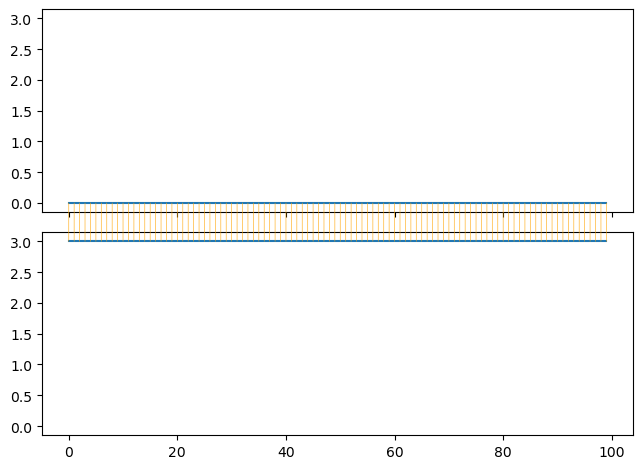

In [59]:
from dtaidistance import dtw


# DTW 거리 계산
distance = dtw.distance(y_test_concat[0], y_pred_classes[0])
print(f"DTW Distance: {distance}")

# 최적의 매칭 경로 시각화
import matplotlib.pyplot as plt
from dtaidistance import dtw_visualisation as dtwvis

dtwvis.plot_warping(y_test_concat[0], y_pred_classes[0], dtw.warping_path(y_test_concat[0], y_pred_classes[0]))
plt.show()

In [60]:
from sklearn.metrics import f1_score
import numpy as np


# Sequence-level F1-Score 계산
f1_scores = []
for true_seq, pred_seq in zip(y_test_concat, y_pred_classes):
    f1 = f1_score(true_seq, pred_seq, average='macro')  # 시퀀스마다 F1-score 계산
    f1_scores.append(f1)

# 시퀀스 별 F1 스코어 출력
print(f"F1-Scores for each sequence: {f1_scores}")
# 평균 F1-score
print(f"Mean F1-Score: {np.mean(f1_scores)}")


F1-Scores for each sequence: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.038461538461538464, 0.0, 0.0196078431372549, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.031746031746031744, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0